<a href="https://colab.research.google.com/github/EhsaasN/cnn_pothole_with_pytorch/blob/main/CNN_POTHOLE_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset,random_split,TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir = '/content/drive/MyDrive/Pothole_Dataset_Final_Remastered_Edition2'

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Verify the folder structure
print(f"Train folder: {os.listdir(train_dir)}")
print(f"Test folder: {os.listdir(test_dir)}")


Train folder: ['Plain', 'Pothole']
Test folder: ['Pothole', 'Plain']


In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label, subfolder in enumerate(['Plain', 'Pothole']):  # 0-> plain, 1->pothole
        subfolder_path = os.path.join(folder, subfolder)
        for filename in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, filename)
            try:
                img = Image.open(file_path)  # Open the image without resizing
                images.append(img)  # Keep the image as a PIL Image object
                labels.append(label)  # Append the corresponding label
            except Exception as e:
                print(f"Error loading image {file_path}: {e}")
    return images, labels

# Loading images and labels from the train and test directories
train_images, train_labels = load_images_from_folder(train_dir)
test_images, test_labels = load_images_from_folder(test_dir)

# Combining both the images for splitting
all_images = train_images + test_images
all_labels = train_labels + test_labels

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Print dataset information

X_train=X_train[:3000]
X_test=X_test[:3000]
y_train=y_train[:3000]
y_test=y_test[:3000]
print(f"Number of training images: {len(X_train)}, Labels: {len(y_train)}")
print(f"Number of testing images: {len(X_test)}, Labels: {len(y_test)}")

Number of training images: 3000, Labels: 3000
Number of testing images: 2197, Labels: 2197


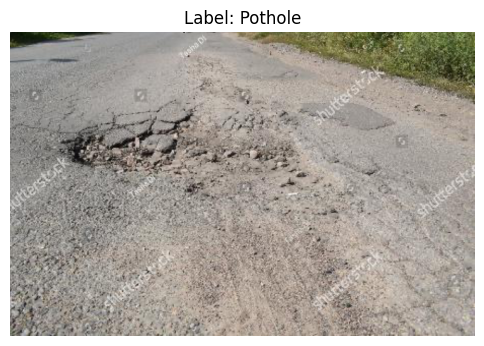

In [ ]:

first_image = X_train[1000]  # First image as a PIL Image object
first_label = y_train[1000]  # Corresponding label (0 for Plain, 1 for Pothole)


plt.figure(figsize=(6, 6))
plt.imshow(first_image)
plt.title(f"Label: {'Plain' if first_label == 0 else 'Pothole'}")
plt.axis('off')
plt.show()


In [ ]:
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
#     transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
#     transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # Randomly crop the image to 28x28 size
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change brightness, contrast, saturation, hue
#     transforms.ToTensor(),  # Convert image to tensor
#     transforms.Normalize((0.5,), (0.5,))  # Normalize the image (mean=0.5, std=0.5 for grayscale)
# ])

# transform = transforms.Compose([
#     transforms.Grayscale(),
#     transforms.Resize((28, 28)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))  # Normalize the image pixels
# ])

# # Function to apply transformations to a list of images
# def apply_transformations(images):
#     transformed_images = []
#     for img in images:
#         transformed_img = transform(img)  # Apply the transformations
#         transformed_images.append(transformed_img)
#     return transformed_images

# # Convert images in X_train and X_test to tensors, grayscale, normalize, and resize
# X_train_transformed = apply_transformations(X_train)
# X_test_transformed = apply_transformations(X_test)

# # Convert labels to tensors (no transformations needed)
# y_train_tensor = torch.tensor(y_train)
# y_test_tensor = torch.tensor(y_test)

# # Convert list of transformed images to tensor
# X_train_tensor = torch.stack(X_train_transformed)
# X_test_tensor = torch.stack(X_test_transformed)

# # Print dataset information
# print(f"X_train tensor shape: {X_train_tensor.shape}")
# print(f"X_test tensor shape: {X_test_tensor.shape}")
# print(f"y_train tensor shape: {y_train_tensor.shape}")
# print(f"y_test tensor shape: {y_test_tensor.shape}")

In [ ]:
# Define a single transformation pipeline
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert image to grayscale
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize (mean=0.5, std=0.5 for grayscale)
])


In [ ]:
# Function to apply transformations and convert to a single tensor
def preprocess_dataset(images):
    return torch.stack([transform(img) for img in images])  # Transform and stack in one step


In [ ]:
# Apply transformations to train and test sets
X_train_tensor = preprocess_dataset(X_train)
X_test_tensor = preprocess_dataset(X_test)

In [ ]:
# Convert labels to tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Print dataset information
print(f"X_train tensor shape: {X_train_tensor.shape}")
print(f"X_test tensor shape: {X_test_tensor.shape}")
print(f"y_train tensor shape: {y_train_tensor.shape}")
print(f"y_test tensor shape: {y_test_tensor.shape}")



X_train tensor shape: torch.Size([3000, 1, 28, 28])
X_test tensor shape: torch.Size([2197, 1, 28, 28])
y_train tensor shape: torch.Size([3000])
y_test tensor shape: torch.Size([2197])


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert image to grayscale
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize (mean=0.5, std=0.5 for grayscale)
])

# Use ImageFolder to load the dataset from a directory
# Ensure your dataset directory has subfolders for each class (e.g., dataset_path/train/class1, dataset_path/train/class2)
dataset_path = "/content/drive/MyDrive/Pothole_Dataset_Final_Remastered_Edition2"  # Replace with your dataset path
train_path = "/content/drive/MyDrive/Pothole_Dataset_Final_Remastered_Edition2/train"
test_path = "/content/drive/MyDrive/Pothole_Dataset_Final_Remastered_Edition2/test"

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Create DataLoaders for batching

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Example: Iterate through the train_loader and check shapes
for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1} - Images shape: {images.shape}, Labels shape: {labels.shape}")
    break  # Remove this break to process all batches


Batch 1 - Images shape: torch.Size([32, 1, 28, 28]), Labels shape: torch.Size([32])


In [ ]:
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(32,64, kernel_size = 3, padding = 1)

    self.fc1 = nn.Linear(64*7*7, 128)
    self.fc2 = nn.Linear(128, 1)
    self.pool = nn.MaxPool2d(2,2)


  def forward(self, x):

    x = self.pool(F.relu(self.conv1(x)))  #output is N x 32 x 14 x 14 (after pooling)
    x = self.pool(F.relu(self.conv2(x)))  #output is N x 64 x 7 x 7 (after pooling)

    x = x.view(-1, 64 * 7 * 7) #flattening the tensor for the output to the FCL(view reshapes the tensor into a 2d tensor,-1 allows pytorch to change it accordingly)
    x = F.relu(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))

    return x


In [ ]:
model = CNN()
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
Epochs = 50

# Ensure GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the GPU
model = model.to(device)

# Training loop
for epoch in range(Epochs):
    running_loss = 0.0  # Accumulates loss value for each batch of images in the current epoch
    correct = 0  # Tracks the number of correctly classified images in the current epoch
    total = 0  # Tracks the total number of images processed in the current epoch

    for images, labels in train_loader:
        # Move data and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Adjust labels shape for loss function compatibility
        labels = labels.unsqueeze(1).float()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = loss_fn(outputs.view(-1), labels.view(-1))

        # Backward pass and optimization
        optimizer.zero_grad()  # Clears the gradients from the previous iteration
        loss.backward()  # Computes the gradient of the loss wrt model parameters
        optimizer.step()  # Updates the model parameters based on the computed gradients

        # Accumulate loss
        running_loss += loss.item()

        # Compute predictions and update accuracy metrics
        predicted = (outputs.view(-1) > 0.5).float()  # Convert predicted probabilities to binary predictions
        correct += (predicted == labels.view(-1)).sum().item()  # Count correct predictions
        total += labels.size(0)  # Update the total number of images processed

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{Epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


Using device: cuda
Epoch 1/50, Loss: 0.3296, Accuracy: 85.5356
Epoch 2/50, Loss: 0.3286, Accuracy: 85.4574
Epoch 3/50, Loss: 0.3265, Accuracy: 85.7143
Epoch 4/50, Loss: 0.3253, Accuracy: 85.6249
Epoch 5/50, Loss: 0.3233, Accuracy: 85.6919
Epoch 6/50, Loss: 0.3211, Accuracy: 85.8036
Epoch 7/50, Loss: 0.3201, Accuracy: 85.9824
Epoch 8/50, Loss: 0.3180, Accuracy: 85.9935
Epoch 9/50, Loss: 0.3168, Accuracy: 86.0494
Epoch 10/50, Loss: 0.3155, Accuracy: 86.2169
Epoch 11/50, Loss: 0.3138, Accuracy: 86.1387
Epoch 12/50, Loss: 0.3128, Accuracy: 86.4515
Epoch 13/50, Loss: 0.3116, Accuracy: 86.4850
Epoch 14/50, Loss: 0.3102, Accuracy: 86.5520
Epoch 15/50, Loss: 0.3088, Accuracy: 86.5855
Epoch 16/50, Loss: 0.3079, Accuracy: 86.7195
Epoch 17/50, Loss: 0.3067, Accuracy: 86.7419
Epoch 18/50, Loss: 0.3053, Accuracy: 86.8536
Epoch 19/50, Loss: 0.3041, Accuracy: 86.9988
Epoch 20/50, Loss: 0.3029, Accuracy: 86.8424
Epoch 21/50, Loss: 0.3018, Accuracy: 87.1440
Epoch 22/50, Loss: 0.3007, Accuracy: 86.9988


In [ ]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the appropriate device
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Initialize variables to keep track of the total loss and accuracy
test_loss = 0.0
correct = 0
total = 0

# Disable gradient calculation for testing
with torch.no_grad():
    # Iterate through the test data
    for images, labels in test_loader:
        # Move data to the same device as the model
        images = images.to(device)
        labels = labels.to(device)

        # Add batch dimension to labels (ensure they are float for BCE)
        labels = labels.unsqueeze(1).float()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = loss_fn(outputs.view(-1), labels.view(-1))
        test_loss += loss.item()  # Add batch loss to the total test loss

        # Compute predictions (threshold at 0.5)
        predicted = (outputs.view(-1) > 0.5).float()

        # Update correct and total counts
        correct += (predicted == labels.view(-1)).sum().item()
        total += labels.size(0)

# Calculate the average loss for the test set
average_test_loss = test_loss / len(test_loader)

# Calculate the accuracy
test_accuracy = 100 * correct / total

# Print the test results
print(f"Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.4532, Test Accuracy: 78.73%


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the appropriate device
model = model.to(device)

image_counter = 0

# Iterate through the entire test dataset to print true and predicted labels for the first 30 images
for images, labels in test_loader:
    # Move the batch of images and labels to the same device as the model
    images = images.to(device)
    labels = labels.to(device)

    for i in range(images.size(0)):
        if image_counter < 30:
            true_label = int(labels[i].item())  # Actual label

            # Get the predicted probability for the current image
            image = images[i].unsqueeze(0)  # Add batch dimension for a single image
            predicted_probability = model(image).item()  # Forward pass

            # Convert probability to predicted class (0 or 1) based on threshold
            predicted_label = 1 if predicted_probability > 0.5 else 0

            # Print the true and predicted labels
            print(f"True label: {true_label}, Predicted label: {predicted_label}")
            image_counter += 1

        if image_counter >= 30:  # Stop after printing 30 images
            break
    if image_counter >= 30:  # Stop after printing 30 images
        break


True label: 0, Predicted label: 1
True label: 0, Predicted label: 0
True label: 0, Predicted label: 1
True label: 1, Predicted label: 1
True label: 0, Predicted label: 0
True label: 0, Predicted label: 1
True label: 0, Predicted label: 0
True label: 1, Predicted label: 1
True label: 0, Predicted label: 0
True label: 0, Predicted label: 0
True label: 0, Predicted label: 0
True label: 0, Predicted label: 1
True label: 0, Predicted label: 0
True label: 0, Predicted label: 1
True label: 0, Predicted label: 0
True label: 1, Predicted label: 1
True label: 1, Predicted label: 1
True label: 0, Predicted label: 0
True label: 0, Predicted label: 0
True label: 1, Predicted label: 1
True label: 1, Predicted label: 1
True label: 1, Predicted label: 1
True label: 0, Predicted label: 0
True label: 0, Predicted label: 0
True label: 0, Predicted label: 0
True label: 1, Predicted label: 1
True label: 0, Predicted label: 0
True label: 1, Predicted label: 1
True label: 0, Predicted label: 1
True label: 0,

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((28, 28)),       # Resize the image to 28x28 (if required by your model)
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if necessary
    transforms.ToTensor(),             # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image
])

# Load the image from your local machine
image_path = '/content/pothole test.jpg'  # Update this path with the image location
image = Image.open(image_path)

# Apply the transformations
image_tensor = transform(image)

# Add an extra batch dimension (since the model expects a batch of images)
image_tensor = image_tensor.unsqueeze(0)  # Shape will be [1, 1, 28, 28] (Batch size of 1)

# Move the model and the image tensor to the same device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)  # Ensure the model is on the correct device
image_tensor = image_tensor.to(device)  # Move the image tensor to the same device

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation since we're in inference mode
with torch.no_grad():
    # Pass the image through the model
    output = model(image_tensor)

    # Apply sigmoid function to get the probability
    predicted = torch.sigmoid(output).item()  # Sigmoid converts to a probability (between 0 and 1)

    # Set the threshold (e.g., 0.6 for higher precision)
    new_threshold = 0.6

    # Get the predicted class
    predicted_class = 1 if predicted > new_threshold else 0

    # Print the results
    print(f"Predicted probability: {predicted:.4f}")
    print(f"Predicted class: {'Pothole' if predicted_class == 1 else 'Plain'}")


Predicted probability: 0.7250
Predicted class: Pothole


In [ ]:
import torch
from sklearn.metrics import classification_report
import numpy as np  # Ensure NumPy is imported

# Set the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the correct device
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Initialize lists to store predictions and labels
all_predictions = []
all_labels = []

# Disable gradient calculation for testing
with torch.no_grad():
    # Iterate through the test data
    for images, labels in test_loader:
        # Move images and labels to the same device as the model
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Apply sigmoid and threshold to get predictions
        predicted = (torch.sigmoid(outputs) > 0.6).float()

        # Extend the lists with predictions and labels from this batch
        all_predictions.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Generate the classification report
print(classification_report(all_labels, all_predictions))


              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1028
           1       0.77      0.84      0.81      1003

    accuracy                           0.80      2031
   macro avg       0.80      0.80      0.80      2031
weighted avg       0.80      0.80      0.80      2031



In [ ]:
import os
from PIL import Image

# ... (your existing code, including model and transforms)

# Directory containing the 10 test images
test_image_dir = '/content/drive/MyDrive/Pothole_Dataset_Final_Remastered_Edition2/test/Plain'  # Update with the correct path

# Get the list of image file names
test_image_files = os.listdir(test_image_dir)[:20]  # Take the first 10 images for testing
model=model.to(device)

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation since we're in inference mode
with torch.no_grad():
    for image_file in test_image_files:
        image_path = os.path.join(test_image_dir, image_file)
        image = Image.open(image_path)

        image_tensor = transform(image)
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor=image_tensor.to(device)
        output = model(image_tensor)
        predicted = torch.sigmoid(output).item()

        # predicted_class = 1 if predicted > 0.5 else 0

        # Choose a new threshold (e.g., 0.6 for higher precision)
        new_threshold = 0.6

        # Now, when making predictions:
        predicted_class = 1 if predicted > new_threshold else 0

        print(f"Image: {image_file}")
        print(f"Predicted probability: {predicted:.4f}")
        print(f"Predicted class: {'Pothole' if predicted_class == 1 else 'Plain'}")
        print("-" * 20)  # Separator for better readability

Image: Japan_001648.jpg
Predicted probability: 0.5038
Predicted class: Plain
--------------------
Image: Japan_002194.jpg
Predicted probability: 0.5073
Predicted class: Plain
--------------------
Image: Japan_000753.jpg
Predicted probability: 0.5239
Predicted class: Plain
--------------------
Image: Japan_002522.jpg
Predicted probability: 0.5074
Predicted class: Plain
--------------------
Image: Japan_000961.jpg
Predicted probability: 0.5308
Predicted class: Plain
--------------------
Image: Japan_000047.jpg
Predicted probability: 0.5188
Predicted class: Plain
--------------------
Image: Japan_000342.jpg
Predicted probability: 0.5003
Predicted class: Plain
--------------------
Image: Japan_002351.jpg
Predicted probability: 0.5443
Predicted class: Plain
--------------------
Image: Japan_002430.jpg
Predicted probability: 0.5141
Predicted class: Plain
--------------------
Image: Japan_001937.jpg
Predicted probability: 0.5093
Predicted class: Plain
--------------------
Image: Japan_000141.

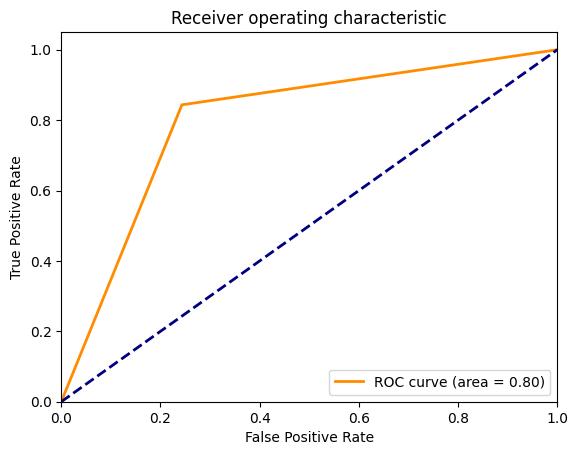

In [ ]:
from sklearn.metrics import roc_curve, auc

# ... (Get your predictions and true labels for the test set: all_predictions, all_labels)

fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve (optional)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Choose a threshold based on your desired trade-off between TPR and FPR
# For example, if you want higher precision, choose a higher threshold.
new_threshold = 0.6


In [ ]:
import pickle

# Save the model object
pkl= "/content/model/cnn_model.pkl"

with open(pkl, "wb") as f:
    pickle.dump(model, f)

print(f"Custom model saved to {pkl}")


Custom model saved to /content/model/cnn_model.pkl
